# Batch Trainings for RLsimulator

In [1]:
import os
import time
import torch
import torch.nn as nn
from utils.seq_data_loader import LoanSimDataset, collate_fn
from torch.utils.data import DataLoader
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rich.console import Console
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
)
from models.variable_list import scale_columns, features, full_targets

In [2]:
console = Console()

In [3]:
# Device setup
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=full_targets,
    group="train",
)


# use the test data as validation data
val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=full_targets,
    group="test",  # read the test data
)

train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


val_dataloader = DataLoader(
    val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [5]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class MultiTaskModel(nn.Module):
    def __init__(
        self,
        # RNN input size, hidden size, and number of layers
        rnn_model,
        input_size,
        rnn_output_size,
        num_layers,
        # MLP hidden layers for each task
        state_pred_hidden_layers=[],
        installment_pred_hidden_layers=[],
        loan_pred_hidden_layers=[],
        recovery_rate_pred_hidden_layers=[],
        # Length of targets for each task
        len_state_targets=7,
        len_installment_targets=1,
        len_loan_targets=1,
        len_recovery_rate_targets=1,
    ):
        super(MultiTaskModel, self).__init__()
        # ------------------------------------
        # rnn Layer as a feature extractor
        if rnn_model == "RNN":
            self.rnn = nn.RNN(input_size, rnn_output_size, num_layers, batch_first=True)
        elif rnn_model == "LSTM":
            self.rnn = nn.LSTM(input_size, rnn_output_size, num_layers, batch_first=True)
        elif rnn_model == "GRU":
            self.rnn = nn.GRU(input_size, rnn_output_size, num_layers, batch_first=True)
        # ------------------------------------
        # MLP for prediction (state, installment, loan, recovery rate)
        # calculate the number of layers for each MLP
        state_pred_layers = (
            [rnn_output_size] + state_pred_hidden_layers + [len_state_targets]
        )
        installment_pred_layers = (
            [rnn_output_size] + installment_pred_hidden_layers + [len_installment_targets]
        )
        loan_pred_layers = [rnn_output_size] + loan_pred_hidden_layers + [len_loan_targets]
        recovery_rate_pred_layers = (
            [rnn_output_size]
            + recovery_rate_pred_hidden_layers
            + [len_recovery_rate_targets]
        )
        # create MLP layers
        state_mlp_layers = []
        installment_mlp_layers = []
        loan_mlp_layers = []
        recovery_rate_mlp_layers = []
        for i in range(len(state_pred_layers) - 1):
            state_mlp_layers.append(
                nn.Linear(state_pred_layers[i], state_pred_layers[i + 1])
            )
            if i < len(state_pred_layers) - 2:
                state_mlp_layers.append(nn.ReLU())
        for i in range(len(installment_pred_layers) - 1):
            installment_mlp_layers.append(
                nn.Linear(installment_pred_layers[i], installment_pred_layers[i + 1])
            )
            if i < len(installment_pred_layers) - 2:
                installment_mlp_layers.append(nn.ReLU())
            else:
                installment_mlp_layers.append(nn.Sigmoid())
        for i in range(len(loan_pred_layers) - 1):
            loan_mlp_layers.append(
                nn.Linear(loan_pred_layers[i], loan_pred_layers[i + 1])
            )
            if i < len(loan_pred_layers) - 2:
                loan_mlp_layers.append(nn.ReLU())
            else:
                loan_mlp_layers.append(nn.Sigmoid())
        for i in range(len(recovery_rate_pred_layers) - 1):
            recovery_rate_mlp_layers.append(
                nn.Linear(
                    recovery_rate_pred_layers[i], recovery_rate_pred_layers[i + 1]
                )
            )
            recovery_rate_mlp_layers.append(nn.ReLU())
        self.state_pred = nn.Sequential(*state_mlp_layers)
        self.installment_pred = nn.Sequential(*installment_mlp_layers)
        self.loan_pred = nn.Sequential(*loan_mlp_layers)
        self.recovery_rate_pred = nn.Sequential(*recovery_rate_mlp_layers)

    def forward(self, x, lengths):  # Accepts raw input and lengths
        # Pack sequence
        packed_x = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.rnn(packed_x)
        rnn_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # Pass through MLP
        state_out = self.state_pred(rnn_out)
        installment_out = self.installment_pred(rnn_out)
        loan_out = self.loan_pred(rnn_out)
        recovery_rate_out = self.recovery_rate_pred(rnn_out)

        return state_out, installment_out, loan_out, recovery_rate_out

In [6]:
def single_parameters_set_training(
    model_name: str,
    # RNN input size, hidden size, and number of layers
    rnn_model: str,
    input_size: int,
    rnn_output_size: int,
    num_layers: int,
    # MLP hidden layers for each task
    state_pred_hidden_layers: list,
    installment_pred_hidden_layers: list,
    loan_pred_hidden_layers: list,
    recovery_rate_pred_hidden_layers: list,
    # Training Parameters
    learning_rate: float,
    num_epochs: int,
    # save the model
    save_model: bool,
):
    # model saved folder is ./Out/{model_name}
    # check if the folder exists, if not, create it
    model_save_folder = f"./Out/{model_name}"
    if not os.path.exists(model_save_folder):
        os.makedirs(model_save_folder)

    model = MultiTaskModel(
        rnn_model=rnn_model,
        input_size=input_size,
        rnn_output_size=rnn_output_size,
        num_layers=num_layers,
        state_pred_hidden_layers=state_pred_hidden_layers,
        installment_pred_hidden_layers=installment_pred_hidden_layers,
        loan_pred_hidden_layers=loan_pred_hidden_layers,
        recovery_rate_pred_hidden_layers=recovery_rate_pred_hidden_layers,
    ).to(device)

    print("The model structure is:")
    print(model)

    # regression question, so use MSE as the Loss function
    mse_criterion = nn.MSELoss()
    # Binary Cross Entropy Loss for the binary classification task
    bce_criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Paras for Early Stopping
    patience = 10  # the number of epochs to wait before stopping training
    best_val_loss = np.inf  # initialize the best validation loss
    counter = 0  # initialize the counter

    # initial weights (equally distributed at the beginning)
    task_weights = [0.25, 0.25, 0.25, 0.25]

    train_losses = []
    val_losses = []

    traing_state_loss_list = []
    training_installment_loss_list = []
    training_loan_loss_list = []
    training_recovery_rate_loss_list = []

    val_state_loss_list = []
    val_installment_loss_list = []
    val_loan_loss_list = []
    val_recovery_rate_loss_list = []

    # for the best model (train)
    best_train_state_mse = None
    best_train_recovery_rate_mse = None
    best_train_installment_done_auc = None
    best_train_loan_done_auc = None
    best_train_installment_done_accuracy = None
    best_train_loan_done_accuracy = None
    best_train_loan_done_f1 = None
    best_train_installment_done_f1 = None
    best_train_loan_done_recall = None
    best_train_installment_done_recall = None
    best_train_installment_done_precision = None
    best_train_loan_done_precision = None
    # for the best model (val)
    best_val_state_mse = None
    best_val_recovery_rate_mse = None
    best_val_installment_done_auc = None
    best_val_loan_done_auc = None
    best_val_installment_done_accuracy = None
    best_val_loan_done_accuracy = None
    best_val_loan_done_f1 = None
    best_val_installment_done_f1 = None
    best_val_loan_done_recall = None
    best_val_installment_done_recall = None
    best_val_installment_done_precision = None
    best_val_loan_done_precision = None

    # add time record
    start_time = time.time()

    for epoch in range(num_epochs):
        print("------------------------------------")
        print(f"Epoch {epoch}")

        model.train()
        running_loss = 0.0
        traing_state_loss = 0.0
        training_installment_loss = 0.0
        training_loan_loss = 0.0
        training_recovery_rate_loss = 0.0

        all_loan_preds = []
        all_loan_targets = []
        all_installment_preds = []
        all_installment_targets = []

        for inputs, targets, lengths in train_dataloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            state_targets = targets[:, :, :7].to(device)
            installment_targets = targets[:, :, 7:8].to(device)
            loan_targets = targets[:, :, 8:9].to(device)
            recovery_rate_targets = targets[:, :, 9:].to(device)

            state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
                inputs, lengths
            )
            state_loss = mse_criterion(state_pred, state_targets)
            installment_loss = bce_criterion(installment_pred, installment_targets)
            loan_loss = bce_criterion(loan_pred, loan_targets)
            recovery_rate_loss = mse_criterion(
                recovery_rate_pred, recovery_rate_targets
            )

            # Dynamic weighted loss
            loss = (
                task_weights[0] * state_loss
                + task_weights[1] * installment_loss
                + task_weights[2] * loan_loss
                + task_weights[3] * recovery_rate_loss
            )

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            traing_state_loss += state_loss.item()
            training_installment_loss += installment_loss.item()
            training_loan_loss += loan_loss.item()
            training_recovery_rate_loss += recovery_rate_loss.item()

            loan_preds = (loan_pred > 0.5).int().cpu().numpy().flatten()
            installment_preds = (installment_pred > 0.5).int().cpu().numpy().flatten()
            loan_targets = loan_targets.cpu().numpy().flatten()
            installment_targets = installment_targets.cpu().numpy().flatten()

            all_loan_preds.extend(loan_preds)
            all_loan_targets.extend(loan_targets)
            all_installment_preds.extend(installment_preds)
            all_installment_targets.extend(installment_targets)

        # 计算平均训练损失
        avg_train_loss = running_loss / len(train_dataloader)
        traing_state_loss = traing_state_loss / len(train_dataloader)
        training_installment_loss = training_installment_loss / len(train_dataloader)
        training_loan_loss = training_loan_loss / len(train_dataloader)
        training_recovery_rate_loss = training_recovery_rate_loss / len(
            train_dataloader
        )

        # calculate AUC, accuracy, F1, recall, and precision on training data
        train_installment_done_auc = roc_auc_score(
            all_installment_targets, all_installment_preds
        )
        train_loan_done_auc = roc_auc_score(all_loan_targets, all_loan_preds)
        train_installment_done_accuracy = accuracy_score(
            all_installment_targets, all_installment_preds
        )
        train_loan_done_accuracy = accuracy_score(all_loan_targets, all_loan_preds)
        train_installment_done_f1 = f1_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        train_loan_done_f1 = f1_score(all_loan_targets, all_loan_preds, zero_division=0)
        train_installment_done_recall = recall_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        train_loan_done_recall = recall_score(
            all_loan_targets, all_loan_preds, zero_division=0
        )
        train_installment_done_precision = precision_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        train_loan_done_precision = precision_score(
            all_loan_targets, all_loan_preds, zero_division=0
        )

        print(f"Training Loss: {avg_train_loss}")
        print(f"Training State Loss: {traing_state_loss}")
        print(f"Training Installment Loss: {training_installment_loss}")
        print(f"Training Loan Loss: {training_loan_loss}")
        print(f"Training Recovery Rate Loss: {training_recovery_rate_loss}")
        print()
        print(f"Training Installment Done AUC: {train_installment_done_auc}")
        print(f"Training Loan Done AUC: {train_loan_done_auc}")
        print(f"Training Installment Done Accuracy: {train_installment_done_accuracy}")
        print(f"Training Loan Done Accuracy: {train_loan_done_accuracy}")
        print(f"Training Installment Done F1: {train_installment_done_f1}")
        print(f"Training Loan Done F1: {train_loan_done_f1}")
        print(f"Training Installment Done Recall: {train_installment_done_recall}")
        print(f"Training Loan Done Recall: {train_loan_done_recall}")
        print(
            f"Training Installment Done Precision: {train_installment_done_precision}"
        )
        print(f"Training Loan Done Precision: {train_loan_done_precision}")
        print()
        train_losses.append(avg_train_loss)
        traing_state_loss_list.append(traing_state_loss)
        training_installment_loss_list.append(training_installment_loss)
        training_loan_loss_list.append(training_loan_loss)
        training_recovery_rate_loss_list.append(training_recovery_rate_loss)

        # Validation Part
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_state_loss = 0.0
            val_installment_loss = 0.0
            val_loan_loss = 0.0
            val_recovery_rate_loss = 0.0

            all_loan_preds = []
            all_loan_targets = []
            all_installment_preds = []
            all_installment_targets = []

            for inputs, targets, lengths in val_dataloader:
                inputs = inputs.to(device)
                state_targets = targets[:, :, :7].to(device)
                installment_targets = targets[:, :, 7:8].to(device)
                loan_targets = targets[:, :, 8:9].to(device)
                recovery_rate_targets = targets[:, :, 9:].to(device)

                state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
                    inputs, lengths
                )

                state_loss = mse_criterion(state_pred, state_targets)
                installment_loss = bce_criterion(installment_pred, installment_targets)
                loan_loss = bce_criterion(loan_pred, loan_targets)
                recovery_rate_loss = mse_criterion(
                    recovery_rate_pred, recovery_rate_targets
                )

                loss = (
                    task_weights[0] * state_loss
                    + task_weights[1] * installment_loss
                    + task_weights[2] * loan_loss
                    + task_weights[3] * recovery_rate_loss
                )

                val_loss += loss.item()
                val_state_loss += state_loss.item()
                val_installment_loss += installment_loss.item()
                val_loan_loss += loan_loss.item()
                val_recovery_rate_loss += recovery_rate_loss.item()

                loan_preds = (loan_pred > 0.5).int().cpu().numpy().flatten()
                installment_preds = (
                    (installment_pred > 0.5).int().cpu().numpy().flatten()
                )
                loan_targets = loan_targets.cpu().numpy().flatten()
                installment_targets = installment_targets.cpu().numpy().flatten()

                all_loan_preds.extend(loan_preds)
                all_loan_targets.extend(loan_targets)
                all_installment_preds.extend(installment_preds)
                all_installment_targets.extend(installment_targets)

            avg_val_loss = val_loss / len(val_dataloader)
            val_state_loss = val_state_loss / len(val_dataloader)
            val_installment_loss = val_installment_loss / len(val_dataloader)
            val_loan_loss = val_loan_loss / len(val_dataloader)
            val_recovery_rate_loss = val_recovery_rate_loss / len(val_dataloader)

            # calculate AUC, accuracy, F1, recall, and precision on validation data
            val_installment_done_auc = roc_auc_score(
                all_installment_targets, all_installment_preds
            )
            val_loan_done_auc = roc_auc_score(all_loan_targets, all_loan_preds)
            val_installment_done_accuracy = accuracy_score(
                all_installment_targets, all_installment_preds
            )
            val_loan_done_accuracy = accuracy_score(all_loan_targets, all_loan_preds)
            val_installment_done_f1 = f1_score(
                all_installment_targets, all_installment_preds, zero_division=0
            )
            val_loan_done_f1 = f1_score(
                all_loan_targets, all_loan_preds, zero_division=0
            )
            val_installment_done_recall = recall_score(
                all_installment_targets, all_installment_preds, zero_division=0
            )
            val_loan_done_recall = recall_score(
                all_loan_targets, all_loan_preds, zero_division=0
            )
            val_installment_done_precision = precision_score(
                all_installment_targets, all_installment_preds, zero_division=0
            )
            val_loan_done_precision = precision_score(
                all_loan_targets, all_loan_preds, zero_division=0
            )

            print(f"Validation Loss: {avg_val_loss}")
            print(f"Validation State Loss: {val_state_loss}")
            print(f"Validation Installment Loss: {val_installment_loss}")
            print(f"Validation Loan Loss: {val_loan_loss}")
            print(f"Validation Recovery Rate Loss: {val_recovery_rate_loss}")
            print()
            print(f"Validation Installment Done AUC: {val_installment_done_auc}")
            print(f"Validation Loan Done AUC: {val_loan_done_auc}")
            print(
                f"Validation Installment Done Accuracy: {val_installment_done_accuracy}"
            )
            print(f"Validation Loan Done Accuracy: {val_loan_done_accuracy}")
            print(f"Validation Installment Done F1: {val_installment_done_f1}")
            print(f"Validation Loan Done F1: {val_loan_done_f1}")
            print(f"Validation Installment Done Recall: {val_installment_done_recall}")
            print(f"Validation Loan Done Recall: {val_loan_done_recall}")
            print(
                f"Validation Installment Done Precision: {val_installment_done_precision}"
            )
            print(f"Validation Loan Done Precision: {val_loan_done_precision}")
            print()

            val_losses.append(avg_val_loss)
            val_state_loss_list.append(val_state_loss)
            val_installment_loss_list.append(val_installment_loss)
            val_loan_loss_list.append(val_loan_loss)
            val_recovery_rate_loss_list.append(val_recovery_rate_loss)

            # -----------------------------------
            # update task weights
            loss_list = [
                val_state_loss,
                val_installment_loss,
                val_loan_loss,
                val_recovery_rate_loss,
            ]
            total_inv_loss = sum(1.0 / l for l in loss_list)
            task_weights = [(1.0 / l) / total_inv_loss for l in loss_list]

            print(f"Updated Task Weights: {task_weights}")

            model_save_path = model_save_folder + f"/{model_name}.pth"
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                counter = 0
                if save_model:
                    torch.save(model.state_dict(), model_save_path)
                print("This training checkpoint has been saved!")

                best_train_state_mse = traing_state_loss
                best_train_recovery_rate_mse = training_recovery_rate_loss
                best_train_installment_done_auc = train_installment_done_auc
                best_train_loan_done_auc = train_loan_done_auc
                best_train_installment_done_accuracy = train_installment_done_accuracy
                best_train_loan_done_accuracy = train_loan_done_accuracy
                best_train_loan_done_f1 = train_loan_done_f1
                best_train_installment_done_f1 = train_installment_done_f1
                best_train_loan_done_recall = train_loan_done_recall
                best_train_installment_done_recall = train_installment_done_recall
                best_train_installment_done_precision = train_installment_done_precision
                best_train_loan_done_precision = train_loan_done_precision

                best_val_state_mse = val_state_loss
                best_val_recovery_rate_mse = val_recovery_rate_loss
                best_val_installment_done_auc = val_installment_done_auc
                best_val_loan_done_auc = val_loan_done_auc
                best_val_installment_done_accuracy = val_installment_done_accuracy
                best_val_loan_done_accuracy = val_loan_done_accuracy
                best_val_loan_done_f1 = val_loan_done_f1
                best_val_installment_done_f1 = val_installment_done_f1
                best_val_loan_done_recall = val_loan_done_recall
                best_val_installment_done_recall = val_installment_done_recall
                best_val_installment_done_precision = val_installment_done_precision
                best_val_loan_done_precision = val_loan_done_precision

            else:
                counter += 1
                if counter >= patience:
                    console.print(
                        "Early stopping at epoch",
                        epoch,
                        "the best validation loss is",
                        best_val_loss,
                        "The model has been saved in",
                        model_save_path,
                        style="bold green",
                    )
                    break
    # stop time record
    end_time = time.time()
    # calculate the total time
    total_time = end_time - start_time
    console.print(f"Total Time: {total_time}", style="bold yellow")

    # plot the training and validation loss (full loss)
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(9, 6))
    plt.plot(
        epochs,
        train_losses,
        label="Train Loss",
        marker="o",
        linestyle="-",
        color="Green",
    )
    plt.plot(
        epochs,
        val_losses,
        label="Validation Loss",
        marker="s",
        linestyle="--",
        color="blue",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # add model parameters to the subtitle
    plt.suptitle(
        "Training and Validation Loss (LSTM, Full loss) \n Dynamic Weight Approach",
        weight="bold",
        size=12,
    )
    plt.title(
        f"Hidden size: {rnn_output_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
    )

    plt.legend()
    plt.grid(True)

    # save the plot
    # plt.savefig("training_validation_loss_lstm.png")
    plt.savefig(f"./Out/{model_name}/training_validation_loss.png")

    # -----------------------------------------------------------------

    # a plot with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    # plot 1: traing_state_loss_list and val_state_loss_list
    axs[0, 0].plot(
        epochs, traing_state_loss_list, label="Train State Loss", color="red"
    )
    axs[0, 0].plot(
        epochs, val_state_loss_list, label="Validation State Loss", color="orange"
    )
    axs[0, 0].set_title("State Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # plot 2: training_installment_loss_list and val_installment_loss_list
    axs[0, 1].plot(
        epochs,
        training_installment_loss_list,
        label="Train Installment Loss",
        color="blue",
    )
    axs[0, 1].plot(
        epochs,
        val_installment_loss_list,
        label="Validation Installment Loss",
        color="purple",
    )
    axs[0, 1].set_title("Installment Loss")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # plot 3: training_loan_loss_list and val_loan_loss_list
    axs[1, 0].plot(
        epochs, training_loan_loss_list, label="Train Loan Loss", color="green"
    )
    axs[1, 0].plot(
        epochs, val_loan_loss_list, label="Validation Loan Loss", color="brown"
    )
    axs[1, 0].set_title("Loan Loss")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # plot 4: training_recovery_rate_loss_list and val_recovery_rate_loss_list
    axs[1, 1].plot(
        epochs,
        training_recovery_rate_loss_list,
        label="Train Recovery Rate Loss",
        color="magenta",
    )
    axs[1, 1].plot(
        epochs,
        val_recovery_rate_loss_list,
        label="Validation Recovery Rate Loss",
        color="black",
    )
    axs[1, 1].set_title("Recovery Rate Loss")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add model parameters to the subtitle
    suptitle = f"Dynamic Weight Approach \n Hidden size: {rnn_output_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
    plt.suptitle(
        "Training and Validation Loss (LSTM)" + "\n" + suptitle, weight="bold", size=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.show()
    plt.savefig(f"./Out/{model_name}/training_validation_loss_subplots.png")

    return {
        # model parameters
        "Model Name": model_name,
        "RNN Model": rnn_model,
        "Input Size": input_size,
        "RNN Output Size": rnn_output_size,
        "Number of Layers": num_layers,
        "State Pred Hidden Layers": state_pred_hidden_layers,
        "Installment Pred Hidden Layers": installment_pred_hidden_layers,
        "Loan Pred Hidden Layers": loan_pred_hidden_layers,
        "Recovery Rate Pred Hidden Layers": recovery_rate_pred_hidden_layers,
        "Learning Rate": learning_rate,
        "Number of Epochs": num_epochs,
        # model structure
        "Model Structure": model,
        # training results
        "Best Train State MSE": best_train_state_mse,
        "Best Train Recovery Rate MSE": best_train_recovery_rate_mse,
        "Best Train Installment Done AUC": best_train_installment_done_auc,
        "Best Train Loan Done AUC": best_train_loan_done_auc,
        "Best Train Installment Done Accuracy": best_train_installment_done_accuracy,
        "Best Train Loan Done Accuracy": best_train_loan_done_accuracy,
        "Best Train Loan Done F1": best_train_loan_done_f1,
        "Best Train Installment Done F1": best_train_installment_done_f1,
        "Best Train Loan Done Recall": best_train_loan_done_recall,
        "Best Train Installment Done Recall": best_train_installment_done_recall,
        "Best Train Installment Done Precision": best_train_installment_done_precision,
        "Best Train Loan Done Precision": best_train_loan_done_precision,
        # validation results
        "Best Validation State MSE": best_val_state_mse,
        "Best Validation Recovery Rate MSE": best_val_recovery_rate_mse,
        "Best Validation Installment Done AUC": best_val_installment_done_auc,
        "Best Validation Loan Done AUC": best_val_loan_done_auc,
        "Best Validation Installment Done Accuracy": best_val_installment_done_accuracy,
        "Best Validation Loan Done Accuracy": best_val_loan_done_accuracy,
        "Best Validation Loan Done F1": best_val_loan_done_f1,
        "Best Validation Installment Done F1": best_val_installment_done_f1,
        "Best Validation Loan Done Recall": best_val_loan_done_recall,
        "Best Validation Installment Done Recall": best_val_installment_done_recall,
        "Best Validation Installment Done Precision": best_val_installment_done_precision,
        "Best Validation Loan Done Precision": best_val_loan_done_precision,
        # total time
        "Total Time": total_time,
    }

The model structure is:
MultiTaskModel(
  (rnn): LSTM(21, 64, num_layers=3, batch_first=True)
  (state_pred): Sequential(
    (0): Linear(in_features=64, out_features=7, bias=True)
  )
  (installment_pred): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (loan_pred): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (recovery_rate_pred): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): ReLU()
  )
)
------------------------------------
Epoch 0
Training Loss: 0.3500471378923679
Training State Loss: 0.2654495028094674
Training Installment Loss: 0.666891619867208
Training Loan Loss: 0.4639776539893783
Training Recovery Rate Loss: 0.003869779155546875

Training Installment Done AUC: 0.4985673113428195
Training Loan Done AUC: 0.5471732272738676
Training Installment Done Accuracy: 0.6082676373582173
Training Loan Done Accuracy: 0.9413336618132089
Training Installment Do

Early stopping at epoch 61 the best validation loss is 0.004881006321573461 The model has been saved in 
./Out/LSTM_multi_dynamic_weight/LSTM_multi_dynamic_weight.pth

Total Time: 644.8807201385498

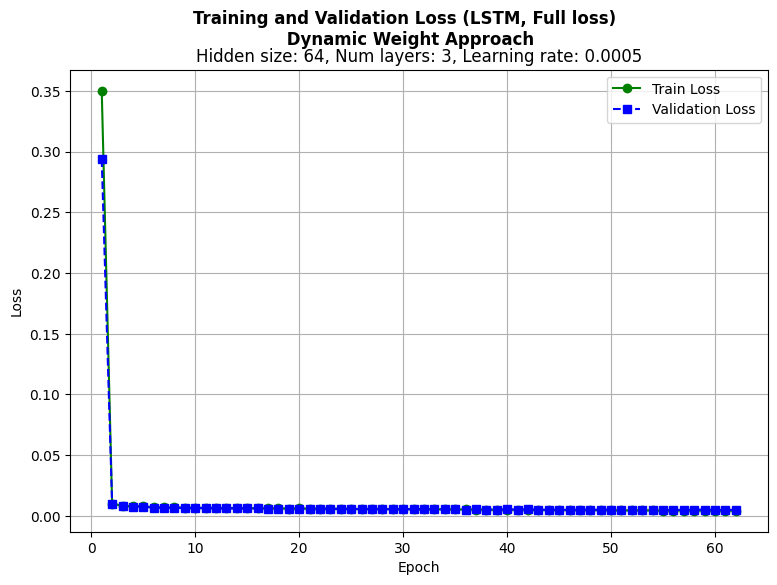

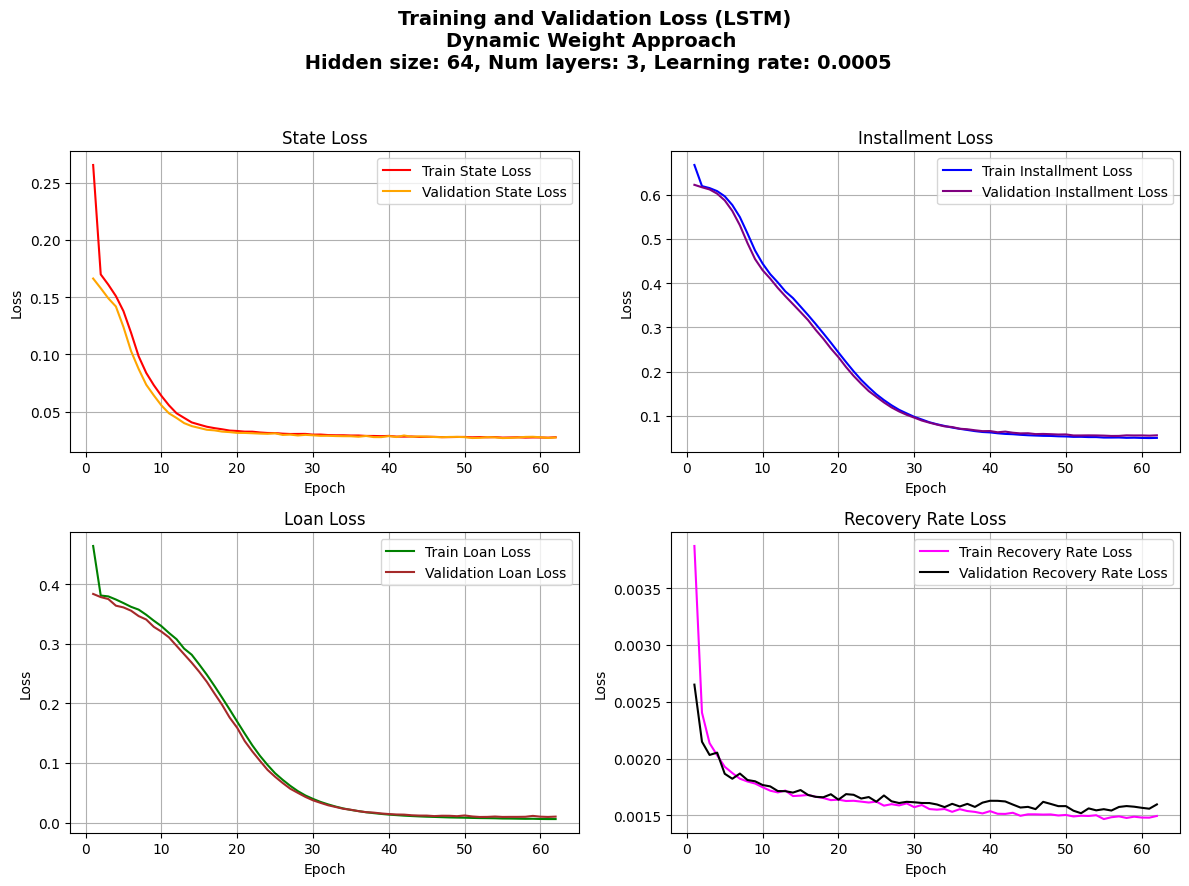

In [7]:
result = single_parameters_set_training(
    model_name="LSTM_multi_dynamic_weight",
    rnn_model="LSTM",
    input_size=len(features),
    rnn_output_size=64,
    num_layers=3,
    state_pred_hidden_layers=[],
    installment_pred_hidden_layers=[],
    loan_pred_hidden_layers=[],
    recovery_rate_pred_hidden_layers=[],
    learning_rate=0.0005,
    num_epochs=100,
    save_model=True
)




In [8]:
result

{'Model Name': 'LSTM_multi_dynamic_weight',
 'RNN Model': 'LSTM',
 'Input Size': 21,
 'RNN Output Size': 64,
 'Number of Layers': 3,
 'State Pred Hidden Layers': [],
 'Installment Pred Hidden Layers': [],
 'Loan Pred Hidden Layers': [],
 'Recovery Rate Pred Hidden Layers': [],
 'Learning Rate': 0.0005,
 'Number of Epochs': 100,
 'Model Structure': MultiTaskModel(
   (rnn): LSTM(21, 64, num_layers=3, batch_first=True)
   (state_pred): Sequential(
     (0): Linear(in_features=64, out_features=7, bias=True)
   )
   (installment_pred): Sequential(
     (0): Linear(in_features=64, out_features=1, bias=True)
     (1): Sigmoid()
   )
   (loan_pred): Sequential(
     (0): Linear(in_features=64, out_features=1, bias=True)
     (1): Sigmoid()
   )
   (recovery_rate_pred): Sequential(
     (0): Linear(in_features=64, out_features=1, bias=True)
     (1): ReLU()
   )
 ),
 'Best Train State MSE': 0.02766846922672905,
 'Best Train Recovery Rate MSE': 0.0014976688483385465,
 'Best Train Installment Do

In [ ]:
# save the result to a csv file in ./Out
import pandas as pd
result_df = pd.DataFrame([result])
result_df.to_excel("./Out/LSTM_multi_dynamic_weight_result.xlsx", index=False)

In [ ]:
import itertools

rnn_models = ["LSTM", "RNN", "GRU"]
rnn_output_sizes = [32, 64]
num_layers_list = [1, 2, 3]


param_combinations = list(
    itertools.product(rnn_models, rnn_output_sizes, num_layers_list)
)
param_combinations

[('LSTM', 32, 1),
 ('LSTM', 32, 2),
 ('LSTM', 32, 3),
 ('LSTM', 64, 1),
 ('LSTM', 64, 2),
 ('LSTM', 64, 3),
 ('RNN', 32, 1),
 ('RNN', 32, 2),
 ('RNN', 32, 3),
 ('RNN', 64, 1),
 ('RNN', 64, 2),
 ('RNN', 64, 3),
 ('GRU', 32, 1),
 ('GRU', 32, 2),
 ('GRU', 32, 3),
 ('GRU', 64, 1),
 ('GRU', 64, 2),
 ('GRU', 64, 3)]